# Acceleration Data Classification

Here is the notebook implementing **Logistic Regression** and **LSTM models** for classifying acceleration data into two classes. The notebook contains data preprocessing, model training, and evaluation. Each section is explained with comments and visualizations for better clarity.


This cell processes the raw CSV data to identify and label motions based on a threshold of Abs_Acc >= 10. Motions within 3 seconds of each other are grouped to handle close motions with small gaps. The result is a cleaned DataFrame with labeled motion segments, ready for further analysis.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/Acceleration Data.csv')

df.columns = ['Time', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Abs_Acc']

df['motion_id'] = 0
motion_id = 0
in_motion = False

for index, row in df.iterrows():
    if row['Abs_Acc'] >= 10:
        if not in_motion:
            motion_id += 1
            in_motion = True
        df.at[index, 'motion_id'] = motion_id
    else:
        in_motion = False

df['label'] = np.where(df['Time'] <= 100, 1, 2)
df = df[df['Abs_Acc'] >= 10].copy()
df = df.sort_values(by='Time').reset_index(drop=True)
df['new_motion_id'] = df['motion_id'].copy()

df = df.reset_index(drop=False)

for i in range(len(df) - 1):
    if df.loc[i + 1, 'Time'] - df.loc[i, 'Time'] < 3:
        df.loc[i + 1, 'new_motion_id'] = df.loc[i, 'new_motion_id']

unique_motions = df['new_motion_id'].unique()
motion_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_motions, start=1)}
df['new_motion_id'] = df['new_motion_id'].map(motion_id_map)
df['motion_id'] = df['new_motion_id']

df = df.drop(columns=['new_motion_id'])



Since time series data can't be directly used in logistic regression, this cell aggregates key features for each motion by calculating summary statistics (mean, standard deviation, min, max, range) for the accelerometer values (Acc_X, Acc_Y, Acc_Z, and Abs_Acc). More complex metrics, like energy, skewness, and correlations, are commented out but can be used if needed. The features are then scaled using StandardScaler to ensure consistent ranges, which is important for the performance of logistic regression.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Abs_Acc']


def aggregate_motion_features(group):
    aggregated_features = {}
    for feature in features:
        aggregated_features[f'{feature}_mean'] = group[feature].mean()
        aggregated_features[f'{feature}_std'] = group[feature].std()
        aggregated_features[f'{feature}_min'] = group[feature].min()
        aggregated_features[f'{feature}_max'] = group[feature].max()
        aggregated_features[f'{feature}_range'] = group[feature].max() - group[feature].min()

        # aggregated_features[f'{feature}_energy'] = np.sum(group[feature] ** 2)
        # aggregated_features[f'{feature}_skew'] = group[feature].skew()
        # aggregated_features[f'{feature}_kurtosis'] = group[feature].kurtosis()
        # aggregated_features[f'{feature}_var'] = group[feature].var()

    # Add correlation between X, Y, Z axes (if needed)
    # aggregated_features['correlation_X_Y'] = group['Acc_X'].corr(group['Acc_Y'])
    # aggregated_features['correlation_Y_Z'] = group['Acc_Y'].corr(group['Acc_Z'])
    # aggregated_features['correlation_X_Z'] = group['Acc_X'].corr(group['Acc_Z'])

    aggregated_features['label'] = group['label'].iloc[0]
    return pd.Series(aggregated_features)

df_aggregated = df.groupby('motion_id').apply(aggregate_motion_features).reset_index()

X = df_aggregated.drop(columns=['label'])
y = df_aggregated['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Preprocessed X_train shape:", X_train.shape)
print("Content")
print("X Train")
print(X)
print("Y Train")
print(y)




Preprocessed X_train shape: (14, 21)
Content
X Train
    motion_id  Acc_X_mean  Acc_X_std  Acc_X_min  Acc_X_max  Acc_X_range  \
0           1   -0.773993   6.873637 -20.287710   8.859100    29.146810   
1           2   -2.647904  11.652741 -34.714480  15.629609    50.344088   
2           3   -2.120319   9.976666 -37.027205  11.095241    48.122447   
3           4   -3.252530  11.222994 -38.993266  15.695184    54.688450   
4           5   -2.650070   8.417041 -20.519718  15.914846    36.434564   
5           6   -2.513931  10.043656 -34.333206  13.268247    47.601453   
6           7   -2.263867   9.634561 -28.863601  16.457167    45.320769   
7           8   -1.329259  10.557253 -33.732447  16.973080    50.705527   
8           9   -1.619321  10.398479 -34.197123  16.512486    50.709608   
9          10   -2.478324  12.916370 -36.316965  22.440042    58.757007   
10         11   -3.054009  12.121860 -23.339196  19.145867    42.485063   
11         12   -4.487353  13.796711 -23.801215

## Logistic Regression Part

In this section, the logistic regression model is used for classifying the acceleration data into two classes. The features are aggregated, and the model's performance is evaluated using accuracy, precision, recall, F1 score, and cross-validation.


This cell loads the LogisticRegression model, trains it on the preprocessed training data (X_train, y_train), and then makes predictions on the test set (X_test).

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)


This cell evaluates the trained logistic regression model by calculating various performance metrics

In [7]:
accuracy_log_reg = accuracy_score(y_test, y_pred)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred)
precision_log_reg = precision_score(y_test, y_pred, average='weighted')
recall_log_reg = recall_score(y_test, y_pred, average='weighted')
f1_log_reg = f1_score(y_test, y_pred, average='weighted')

print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall: {recall_log_reg:.4f}")
print(f"F1 Score: {f1_log_reg:.4f}")
print(f"Confusion Matrix:\n {conf_matrix_log_reg}")

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(log_reg, X_train, y_train, cv=cross_val, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {cross_val_scores.mean():.4f}")


Logistic Regression Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
 [[4 0]
 [0 2]]
Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Cross-Validation Accuracy Scores: [1. 1. 1. 1. 1.]
Mean Cross-Validation Accuracy: 1.0000


The logistic regression model achieved perfect performance, with an accuracy, precision, recall, and F1 score of 1.000. The confusion matrix shows no misclassifications, with all instances correctly predicted. The classification report confirms that both classes (1.0 and 2.0) were perfectly classified. Additionally, cross-validation yielded a mean accuracy of 1.000, with all folds performing perfectly.



These results are excellent for your purpose, as the logistic regression works very well on this dataset. However, the model might be overfitting due to the simplicity of the case, with no challenging or varied instances. It's worth reviewing the dataset and model assumptions to ensure that the evaluation remains realistic for more complex scenarios.

## LSTM Part

In this section, the LSTM model is employed to handle time-series data for classification. The sequences are padded and packed to account for variable lengths, and the model's performance is assessed using loss and accuracy.


This cell prepares the time series data for use in a PyTorch model. The data is first grouped by motion_id, allowing each motion to be treated as a sequence. For each motion, the accelerometer features (Acc_X, Acc_Y, Acc_Z, Abs_Acc) are extracted, and the corresponding label is adjusted to be 0-based (converting 1 to 0, and 2 to 1). Finally, the features and labels are converted into PyTorch tensors, making them ready for use in the model training process.

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

grouped = df.groupby('motion_id')

sequences = []
labels = []
sequence_lengths = []

for _, group in grouped:
    features = group[['Acc_X', 'Acc_Y', 'Acc_Z', 'Abs_Acc']].values
    label = group['label'].values[0] - 1

    seq_len = len(features)
    sequence_lengths.append(seq_len)

    sequences.append(torch.tensor(features, dtype=torch.float32))
    labels.append(torch.tensor(label, dtype=torch.long))


In this cell, the sequences are padded to ensure that all sequences have the same length, which is required for LSTMs to process them in batches. LSTMs expect inputs to have uniform lengths, but time series data often varies in length. By using pad_sequence with a padding value of 0, shorter sequences are extended to match the longest sequence, enabling efficient batch processing while ensuring that the padded values don't affect the model's learning. Additionally, the labels are converted into PyTorch tensors for use in the model.

In [9]:
padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
labels = torch.tensor(labels, dtype=torch.long)

This cell defines a custom MotionDataset class to handle the time series data, which includes sequences, labels, and sequence lengths. The dataset is then split into training and testing sets with a 70/30 ratio using random_split. The DataLoader is used to batch the data for efficient training, with the training set shuffled to improve generalization during training, while the test set is not shuffled. This ensures that the data is fed into the model in manageable batches, which is essential for training with large datasets and helps to optimize the performance of the model.

In [10]:
class MotionDataset(Dataset):
    def __init__(self, sequences, labels, lengths):
        self.sequences = sequences
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx], self.lengths[idx]

dataset = MotionDataset(padded_sequences, labels, sequence_lengths)

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)


This cell defines an LSTM model for time series classification. The model is composed of an LSTM layer followed by a fully connected layer. The LSTM processes sequences of input features, with the hidden_size parameter controlling the number of hidden units, and num_layers allowing the stacking of multiple LSTM layers. The input sequences are packed using pack_padded_sequence, which ensures that the LSTM only processes the non-padded parts of the sequences, making it suitable for variable-length data. After the LSTM processes the sequences, the final hidden state (h_n[-1]) is passed through a fully connected layer to produce the final output, classifying the sequences into their respective labels.

In [11]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        packed_output, (h_n, c_n) = self.lstm(packed_input)

        out = self.fc(h_n[-1])
        return out


The LSTM model is initialized with 4 input features, a hidden size of 50, and 1 layer. It classifies into 2 classes, trained with a learning rate of 0.0005 over 25 epochs. The CrossEntropyLoss criterion is used, and the Adam optimizer updates the model's weights. A function calculates accuracy by comparing predicted and true labels.

In [12]:
input_size = 4
hidden_size = 50
num_layers = 1
num_classes = 2
learning_rate = 0.0005
num_epochs = 25

model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def calculate_accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    return correct / len(y_true)



This function processes one epoch, either for training or evaluation. It computes the model's loss and accuracy on each batch of data. If training, the model's parameters are updated using backpropagation. The function returns the average loss and accuracy for the epoch. Lists are initialized to track loss and accuracy for both training and testing over multiple epochs.

In [13]:
def run_epoch(loader, model, criterion, optimizer=None):
    is_training = optimizer is not None
    total_loss = 0
    correct = 0
    total = 0

    model.train() if is_training else model.eval()

    for sequences_batch, labels_batch, lengths_batch in loader:
        lengths_batch = torch.tensor(lengths_batch, dtype=torch.long)

        outputs = model(sequences_batch, lengths_batch)
        loss = criterion(outputs, labels_batch)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        correct += (torch.max(outputs, 1)[1] == labels_batch).sum().item()
        total += labels_batch.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

This loop runs for the specified number of epochs, training the model and evaluating its performance after each epoch. Training and testing losses and accuracies are recorded. Every 5 epochs (or at the final epoch), the training and test results are printed, showing the model's performance during the training process.

In [14]:
for epoch in range(num_epochs):
    train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    test_loss, test_acc = run_epoch(test_loader, model, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

<ipython-input-13-4b6f9235fdd2>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_batch = torch.tensor(lengths_batch, dtype=torch.long)


Epoch [5/25]
Train Loss: 0.6970, Train Accuracy: 0.4286
Test Loss: 0.5720, Test Accuracy: 0.6667
Epoch [10/25]
Train Loss: 0.5205, Train Accuracy: 0.9286
Test Loss: 0.5239, Test Accuracy: 1.0000
Epoch [15/25]
Train Loss: 0.3912, Train Accuracy: 0.8571
Test Loss: 0.4931, Test Accuracy: 1.0000
Epoch [20/25]
Train Loss: 0.3157, Train Accuracy: 0.8571
Test Loss: 0.4535, Test Accuracy: 1.0000
Epoch [25/25]
Train Loss: 0.2630, Train Accuracy: 0.8571
Test Loss: 0.4168, Test Accuracy: 1.0000


This code generates two subplots: one showing the loss and another showing accuracy over the epochs for both training and testing sets. The graphs provide a visual representation of the model's performance, helping to assess improvements in both loss reduction and accuracy during training.

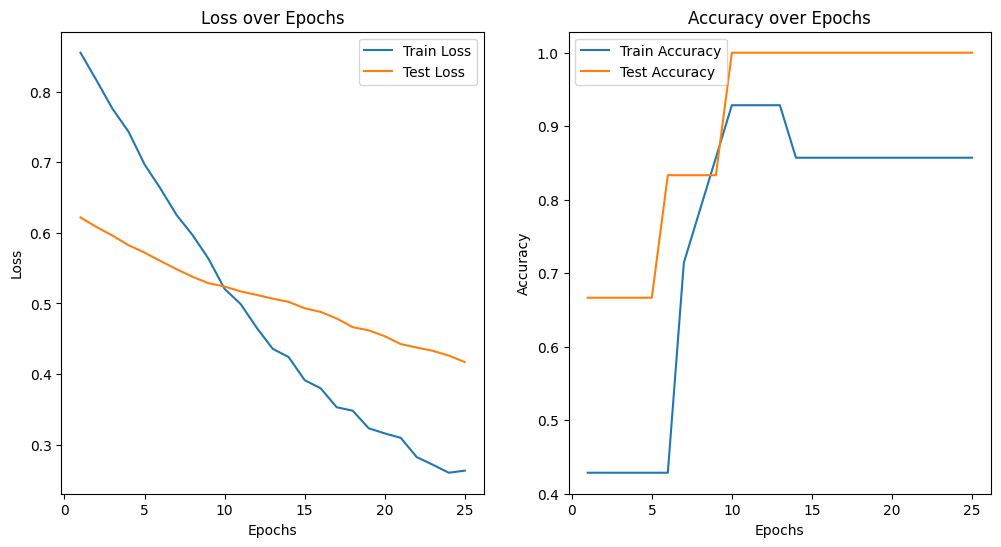

In [15]:
import matplotlib.pyplot as plt

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

The left plot shows the loss decreasing steadily over the epochs for both training and test sets, indicating that the model is learning well and generalizing effectively to unseen data. The right plot shows the accuracy sharply increasing after a few epochs, achieving perfect accuracy early in the training process. Both training and test accuracy plateau at 100%, suggesting that the model has fit the data perfectly, which may indicate that the dataset is relatively simple or possibly overfitted, similarly to the logistic regression results